<a href="https://colab.research.google.com/github/giuliacampesan/LaboratoryOfComputationalPhysics_Y3/blob/development/09ex_Numba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [12]:
 import numpy as np
 import numba
 from numba import cuda , vectorize, int64, float32
 @vectorize([float32(float32)])
 def exp(x):
   return np.exp(x)
 def log(x):
   return np.log(x)

A = np.asarray([2, 5, 10, 3, 8]).astype(np.float32)

print(log(A))
print(exp(A))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

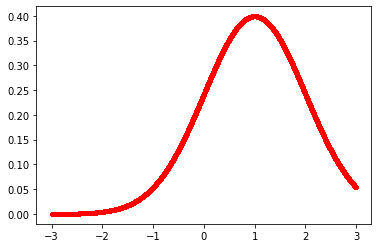

In [50]:
import math as m
import matplotlib.pyplot as plt

@vectorize([float64(float64, int64, int64)])
def gaussian(x, mean,sigma):
  return 1./(m.sqrt(2.*m.pi)*sigma)*m.exp(-m.pow((x - mean)/sigma, 2.)/2)

x = np.random.uniform(-3,3, 100000)
mean = 1
sigma = 1
y=gaussian(x,mean, sigma)
plt.plot(x,y, '.', color='red')

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

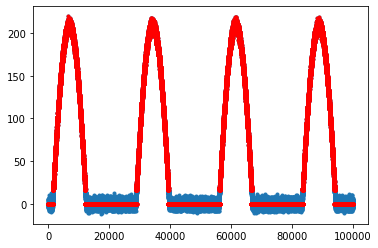

In [59]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

plt.plot(data, '.')

@vectorize([float64(float64, int64)])
def zero_supp(x, treshold):
  if x <= 15:
    return 0
  else:
     return x

threshold = 15
data = zero_supp(data, threshold)
plt.plot(data, '.', color='red')
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [14]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

from numba import cuda
import math

X = np.random.rand(3,3).astype('float64')
Y = np.random.rand(3,3).astype('float64')
res = np.zeros((3,3), dtype='float64')


@cuda.jit
def sigmoid_kernel(x, y, result, a, c):    
    
    row, col = cuda.grid(2)
    
    if row < result.shape[0] and col < result.shape[1]:
        tmp = 0.
        for k in range(x.shape[0]):
            tmp += x[k, row] * y[k, col]
        
        result[row, col] = math.tanh(a * tmp + c)

        
sigmoid_kernel[(1,1),(3,3)](X, Y, res, 1., 1.)

print(res)




[[0.88060485 0.81685009 0.91849496]
 [0.96081709 0.94014119 0.95347308]
 [0.89576591 0.82131785 0.91442054]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [22]:

M = np.random.rand(256,256,256)

@cuda.jit
def cosine_kernel(M):
  row, col, side = cuda.grid(3)
  if row < M.shape[0] and col < M.shape[1] and side <M.shape[2]:
    M[row][col][side] = math.cos(M[row][col][side])
 
 
threadsperblock = (8,8,8)
blockspergrid_x = int(math.ceil(M.shape[0] / threadsperblock[0]))
blockspergrid_y = math.ceil(M.shape[1]/threadsperblock[1])
blockspergrid_z = math.ceil(M.shape[2]/threadsperblock[2])

blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

cosine_kernel[blockspergrid, threadsperblock](M)
M

array([[[0.94718003, 0.99759124, 0.98601333, ..., 0.7779399 ,
         0.98072823, 0.80518463],
        [0.55758688, 0.96712441, 0.74106729, ..., 0.71456844,
         0.95966703, 0.98686653],
        [0.55096361, 0.88820673, 0.97633025, ..., 0.92574884,
         0.99988075, 0.98580363],
        ...,
        [0.97485852, 0.93984296, 0.90795654, ..., 0.99931715,
         0.84219394, 0.81418603],
        [0.74481862, 0.99700345, 0.98249049, ..., 0.97954662,
         0.72496594, 0.86740888],
        [0.58484886, 0.70422191, 0.97272578, ..., 0.93565687,
         0.9450382 , 0.9112474 ]],

       [[0.56668714, 0.81194858, 0.67116692, ..., 0.71599586,
         0.97490824, 0.71943734],
        [0.95531643, 0.92184423, 0.91969052, ..., 0.58679839,
         0.65675361, 0.99608116],
        [0.9852425 , 0.66484949, 0.91011492, ..., 0.9761214 ,
         0.78277688, 0.90778371],
        ...,
        [0.93293464, 0.98100276, 0.99997258, ..., 0.84052848,
         0.99145634, 0.98031305],
        [0.9

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [24]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.rand(24,12)
B = np.random.rand(12,22)
C = np.zeros((24,22))

# Configure the blocks
threadsperblock = (8,8)
blockspergrid_x = math.ceil(M.shape[0]/threadsperblock[0])
blockspergrid_y = math.ceil(M.shape[1]/threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A,B,C)
C


array([[2.40184232, 2.42655311, 3.71048787, 3.64779026, 3.2440376 ,
        2.86708324, 2.09193032, 3.70504511, 2.99906522, 4.00095454,
        3.45321951, 2.63009872, 3.9246115 , 4.07970302, 3.21842893,
        2.99945466, 3.14466139, 2.3877576 , 3.49158076, 3.29529635,
        2.41329689, 3.14113207],
       [2.71118758, 3.05063702, 3.68297291, 2.94968193, 4.02539097,
        3.36542482, 3.39671814, 3.93405798, 3.13423132, 4.19059082,
        4.29902052, 2.57089017, 3.72555047, 3.30931175, 3.21875188,
        2.43095779, 2.99670399, 2.34133843, 2.76159417, 3.71621002,
        2.19420216, 2.6638074 ],
       [2.8294656 , 3.19735864, 4.67058915, 3.04651591, 4.74348655,
        3.49386166, 3.70242525, 4.51732384, 3.61422781, 4.52095248,
        4.68769993, 2.36266645, 4.15079601, 3.81591523, 4.16346409,
        2.84742906, 3.30501263, 3.35969046, 3.4461568 , 4.42138748,
        3.04831369, 3.09666303],
       [2.24330341, 3.04657217, 3.30035189, 2.77907366, 3.8128964 ,
        2.8979653